In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../..

/home/nassim/dev/conrl


In [3]:
from src.qlearning import QLearningAgent
from src.utils import *
from src.plotting import *

import gym
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc

%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=80)

## Discretization visualization

In [4]:
env = gym.make('MountainCar-v0')
print('State Space ', env.observation_space) # Position and Velocity
print(' * Low ', env.observation_space.low)
print(' * High ', env.observation_space.high)
print('State Space sample', env.observation_space.sample())
print('Action Space ', env.action_space) # 0(push left), 1(no push), 2(push right)


State Space  Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
 * Low  [-1.2  -0.07]
 * High  [0.6  0.07]
State Space sample [ 0.583 -0.018]
Action Space  Discrete(3)


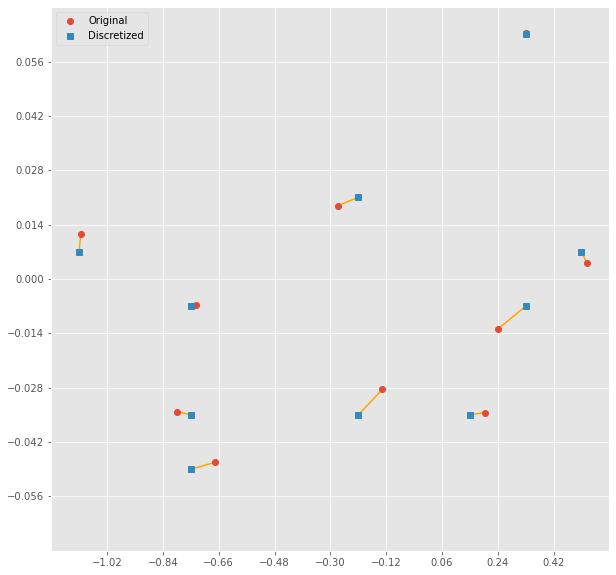

In [5]:
# Discretization parameters
state_size = (10, 10)
window_size = (env.observation_space.high - env.observation_space.low)/state_size

state_grid = create_discretization_grid(env.observation_space.low, env.observation_space.high)
samples = np.array([env.observation_space.sample() for i in range(10)])
discretized_samples = np.array([get_discrete_state(sample, window_size, env) for sample in samples])
visualize_samples(samples, discretized_samples, state_grid, env.observation_space.low, env.observation_space.high)

## QLearning MountainCar

In [15]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 2000
max_step = 1000
env.env._max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.01
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)



In [16]:
stats_q =   {
            "step":  np.zeros(num_episodes),
            "cumulative_reward":  np.zeros(num_episodes),
            "q_tables": np.zeros(shape = (num_episodes, ) + state_size + (env.action_space.n, )),
            "best_actions": []
            }

q_agent = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)

q_agent.train(env, num_episodes, stats_q)

Episode 50/2000, Reward -1000.0, Average Max Reward: -1000.0, Total steps 1000.0, Epsilon: 0.86, Alpha: 0.10, Time 0.069
Episode 100/2000, Reward -1000.0, Average Max Reward: -988.3, Total steps 1000.0, Epsilon: 0.81, Alpha: 0.10, Time 0.072
Episode 150/2000, Reward -1000.0, Average Max Reward: -974.8, Total steps 1000.0, Epsilon: 0.77, Alpha: 0.10, Time 0.069
Episode 200/2000, Reward -1000.0, Average Max Reward: -963.0, Total steps 1000.0, Epsilon: 0.72, Alpha: 0.10, Time 0.078
Episode 250/2000, Reward -1000.0, Average Max Reward: -901.5, Total steps 1000.0, Epsilon: 0.68, Alpha: 0.10, Time 0.072
Episode 300/2000, Reward -1000.0, Average Max Reward: -912.2, Total steps 1000.0, Epsilon: 0.63, Alpha: 0.10, Time 0.074
Episode 350/2000, Reward -1000.0, Average Max Reward: -930.5, Total steps 1000.0, Epsilon: 0.59, Alpha: 0.10, Time 0.086
Episode 400/2000, Reward -997.0, Average Max Reward: -609.7, Total steps 997.0, Epsilon: 0.54, Alpha: 0.10, Time 0.081
Episode 450/2000, Reward -1000.0, 

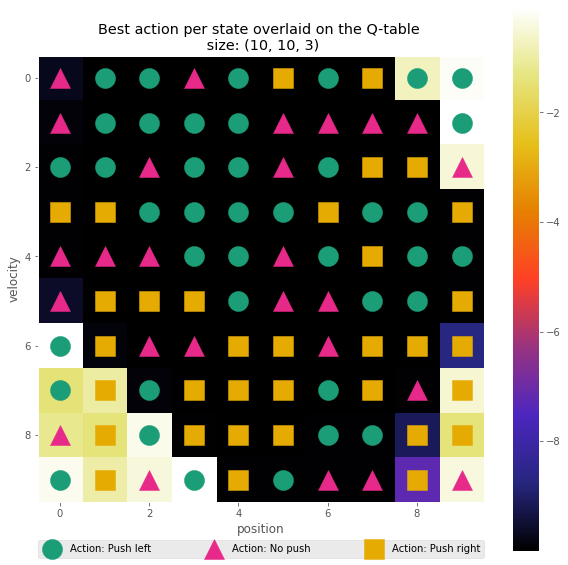

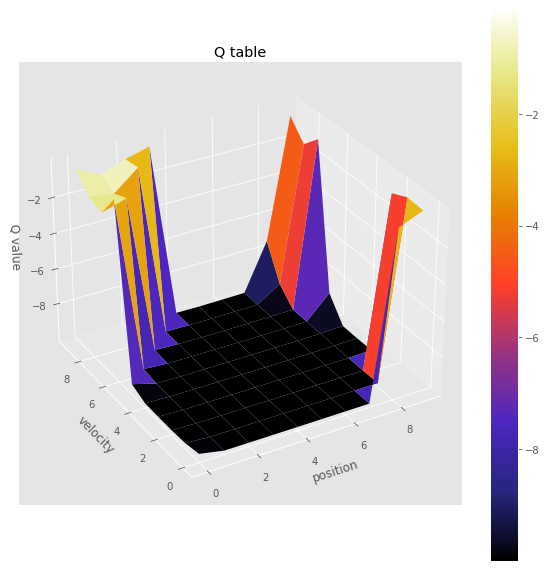

In [21]:
act_dict = {
    0: "Push left",
    1: "No push",
    2: "Push right"
}

act_symbol = {
    0:  "o",
    1: "^",
    2: "s",
}

#act_color = [plt.cm.viridis_r(i) for i in np.linspace(0.1, 1, 3, endpoint=False)]
act_color = cm.Dark2(np.linspace(0.1, 1, 3, endpoint=False))

plot_q_table(   q_table=stats_q["q_tables"][-1], 
                action_names=act_dict, 
                symbols=act_symbol, 
                colors=act_color,
                title="Best action per state overlaid on the Q-table",
                axis_names=["position", "velocity"])
plot_q_table_3d(q_table=stats_q["q_tables"][-1], 
                state_size=state_size,
                title="Q table",
                axis_names=["position", "velocity", "Q value"])

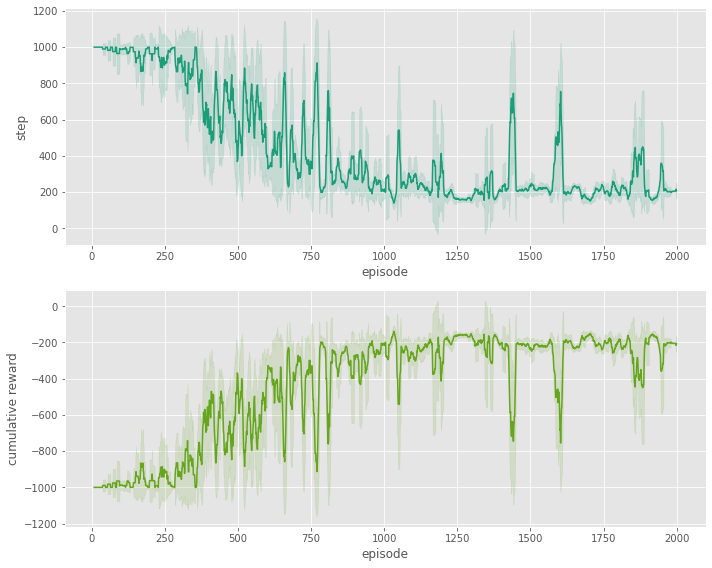

In [18]:
to_plot = ["step", "cumulative_reward"]

stats_to_plot = {key: value for key, value in stats_q.items() if key in to_plot}
plot_stats(stats_to_plot, figsize=(10, 8))